# Import libraries

In [ ]:
# mamba install gpy

In [ ]:
pip install tensorflow

In [ ]:
pip install parameter-sherpa

In [ ]:
pip install shap

In [27]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
import tensorflow
import io
import os
from PIL import Image
import seaborn as sns

import tensorflow as tf
import tensorflow.math
from tensorflow import keras
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap

plt.rcParams['figure.figsize'] = (12,12)

# Load MAR output

#### Load local MAR output for 2020 on 6.5km

In [2]:
ds2020 = xr.open_dataset('/home/jovyan/MARv3.12-6_5km-daily-ERA5-2020.nc')

In [5]:
LAT = np.load('./LAT.npy')
LON = np.load('./LON.npy')
AL2_2020 = np.load('./AL2_2020.npy')

#### Load bare ice variable (from Antwerpen et al., 2022). This variables gives 1's for bare ice and NaNs for non-bare ice (snow, land, or ocean) daily for June, July, and August in 2000-2021

In [6]:
ds_bie = sio.loadmat('/home/jovyan/sboth_6km.mat')

#### Flip matrix right-side up and change dimension order

In [7]:
bareice = np.flipud(ds_bie['sboth_6km'])
bareice = np.transpose(bareice, (3, 0, 1, 2))

In [8]:
bareice_sub = bareice[:,:,:,9:21]

In [9]:
numberdaystot = 1104

bareice0920 = np.zeros((numberdaystot,415,230))

for i in range(12):
    bareice0920[i*92:i*92+92,:,:] = bareice_sub[:,:,:,i]

#### Load variables from MAR for June, July, and August in 2020 and place them in new variable 'x'. Variables loaded: surface temperature (ST2), liquid water content (WA1), shortwave radiation up/down (SWU/SWD), longwave radiation up/down (LWU/LWD), sensible heat flux (SHF), latent heat flux (LHF), x-wind speed component (UU), y-wind speed component (VV), surface pressure (SP), sublimation from snow/soil (SU), snowfall (SF), rainfall (RF), cloud cover up/middle/down (CU/CM/CD), cloud optical depth (COD), density (RO1), surface height (SH), soil type (SOL)

In [10]:
jun1 = 151
aug31 = 242
numberdays = aug31-jun1+1

jun1_leap = jun1 + 1
aug31_leap = aug31 + 1

numberyears = 12

n_feature = 19
n_lat = int(415/2)
n_lon = 100

In [7]:
x = np.zeros((numberyears, numberdays, n_lat, n_lon, n_feature))

x[11,:,:,:,0] = ds2020.ST2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[11,:,:,:,1] = ds2020.SWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,2] = ds2020.SWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,3] = ds2020.LWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,4] = ds2020.LWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,5] = ds2020.SHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,6] = ds2020.LHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,7] = ds2020.SP.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,8] = np.mean(ds2020.RO1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[11,:,:,:,9] = ds2020.AL2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[11,:,:,:,10] = ds2020.UU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[11,:,:,:,11] = ds2020.VV.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[11,:,:,:,12] = ds2020.SU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[11,:,:,:,13] = np.mean(ds2020.WA1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[11,:,:,:,14] = ds2020.SF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31_leap-jun1_leap+1):
    x[11,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[11,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]

In [8]:
x = x[:,:,:,:,:].reshape(numberdaystot, 207, 100, 17)

In [ ]:
x = np.load('./x.npy')

In [ ]:
np.shape(x)

# Load MODIS albedo data

#### Load MODIS albedo data for June, July, and August in 2020

In [13]:
path = '/home/jovyan/MOD10A1_albedo_MARproj_6_5km/'
dir_list = np.sort(os.listdir(path))
dir_list = dir_list[1:]
dir_list

array(['20090601_albedo.tif', '20090602_albedo.tif',
       '20090603_albedo.tif', ..., '20200829_albedo.tif',
       '20200830_albedo.tif', '20200831_albedo.tif'], dtype='<U19')

#### Flip matrix right-side up and place in new matrix 'y'

In [14]:
y = np.zeros((numberdaystot,415,230,1))

for i in range (0,len(dir_list)):
    f = dir_list[i]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

#### Turn 255's into NaNs, divide by 100 to get albedo in 0-1 range, and multiply with bare ice matrix to extract only bare ice albedo values

In [15]:
y = np.where(y == 255, np.nan, y)
y = y/100
y = y[:,:,:,0] * bareice0920

# Only run if using SW quadrant

In [16]:
n_lat = 207
n_lon = 100

x = x[:,:n_lat,:n_lon,:]
y = y[:,:n_lat,:n_lon]

In [17]:
y.shape

(1104, 207, 100)

In [13]:
y = np.load('./y.npy')

# Prepare data for training and testing

#### Standardize the data so all values are in the 0-range, plusminus a couple (2-5).

In [14]:
x_dum = np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
for i in range(x.shape[3]):
    
    mean, std = np.nanmean(x[:,:,:,i]), np.nanstd(x[:,:,:,i])
        
    x_dum[:,:,:,i]   = (x[:,:,:,i] - mean)/std
    
    if i == 9:
        AL2_mean, AL2_std = np.nanmean(x[:,:,:,i]), np.nanstd(x[:,:,:,i])

x = x_dum

In [ ]:
# remove AL2 from x

In [ ]:
# x_withAL2 = x

In [ ]:
# x2 = np.zeros((1104,207,100,18))
# x2[:,:,:,:9] = x[:,:,:,:9]
# x2[:,:,:,9:] = x[:,:,:,10:]
# x = x2

#### Create mask of valid albedo pixels and only use pixels that have a realistic albedo value (> 0.1)

In [15]:
y_masknan = np.where(y > 0.1, 1, np.nan)
y_mask = y * y_masknan
x_mask = np.zeros((numberdaystot,207,100,19))
for i in range(19):
    x_mask[:,:,:,i] = x[:,:,:,i] * y_masknan[:,:,:]

In [16]:
np.sum(~np.isnan(x_mask)) / 19

299319.0

In [17]:
y_nonan = y_mask[~np.isnan(y_mask)]

x_nonan = np.zeros((299319,19))

for i in range(19):
    x_mask_dum = x_mask[:,:,:,i]
    x_nonan[:,i] = x_mask_dum[~np.isnan(x_mask_dum)]

In [18]:
np.shape(x_nonan)

(299319, 19)

#### Split data into training (80%) and testing (20%)

In [19]:
X_train1, X_test, y_train1, y_test = train_test_split(x_nonan, y_nonan, test_size=(1/12), shuffle=False)

In [20]:
X_train1.shape, X_test.shape, y_train1.shape, y_test.shape

((274375, 19), (24944, 19), (274375,), (24944,))

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=(1/11), shuffle=False)

In [22]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((249431, 19), (24944, 19), (249431,), (24944,))

# Initialize and run RF model

In [44]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,105, num = 21)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [45]:
print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, None], 'min_samples_split': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 'min_samples_leaf': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40], 'bootstrap': [True, False]}


In [ ]:
reg0 = RandomForestRegressor(random_state=0)
# perform cross validation
rf_random0 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 150, cv = 5, verbose=2, n_jobs = -1, scoring='accuracy')
rf_tas = rf_random0.fit(X_train,y_train)

print("The best hyperparameters: \n",rf_tas.best_params_)

In [24]:
n_estimators      = 150   # Number of trees in random forest
min_samples_split = 30     # Minimum number of samples required to split a node
min_samples_leaf  = 32      # Minimum number of samples required at each leaf node
max_features      = 'auto' #'sqrt' # Number of features to consider at every split
max_depth         = 100    # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

In [25]:
reg0 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

In [26]:
rf_tas = reg0.fit(X_train,y_train)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


In [28]:
reg0.score(X_train,y_train), reg0.score(X_test,y_test), reg0.score(X_val,y_val)

(0.6299179985900976, 0.45071250908333305, 0.49616235152708776)

# Evaluate the model

In [29]:
y_test_pre = rf_tas.predict(X_test)

In [30]:
AL2_test = (X_test[:,9] * AL2_std) + AL2_mean

In [40]:
np.shape(y_test_pre)

(24944,)

In [52]:
R2_MODIS_RF = ma.corrcoef(y_test, y_test_pre)[1,0]**2
R2_MODIS_RF

0.45273489722017896

In [49]:
R2_MODIS_MAR = ma.corrcoef(y_test, AL2_test)[1,0]**2
R2_MODIS_MAR

0.06856590668961822

In [51]:
mean_squared_error(y_test, y_test_pre)

0.008810927341706323

In [34]:
mean_squared_error(y_test, AL2_test)

0.0354187329761596

In [37]:
np.nanmean(y_test), np.nanmean(y_test_pre)

(0.4292515234124439, 0.43287053683925103)

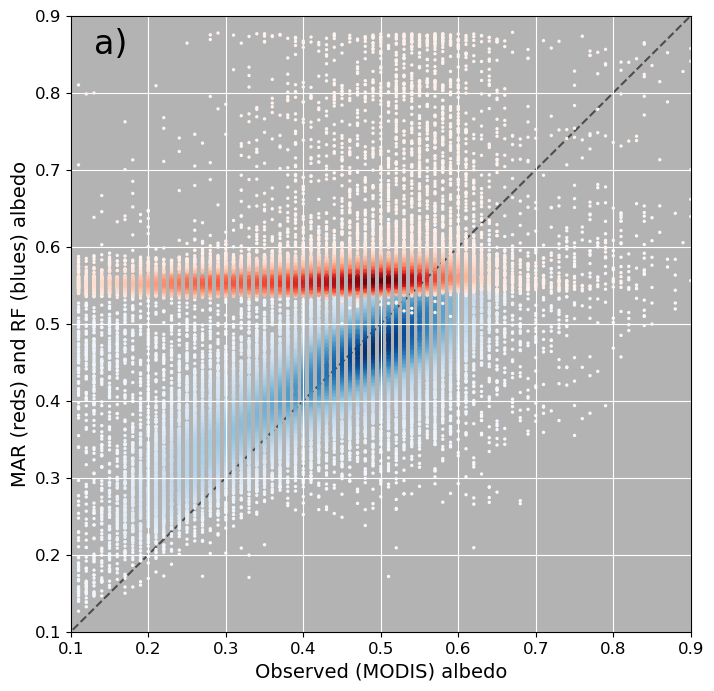

In [35]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()

# Calculate the point density
xy1 = np.vstack([y_test, y_test_pre])
z1 = gaussian_kde(xy1)(xy1)
xy2 = np.vstack([y_test, AL2_test])
z2 = gaussian_kde(xy2)(xy2)

plt.plot(np.arange(-1,1,0.1), np.arange(-1,1,0.1), color=[0.3, 0.3, 0.3], linestyle='--', linewidth=1.5, zorder=1)
plt.scatter(y_test, y_test_pre, c=z1, s=2, zorder=1, cmap='Blues')
plt.scatter(y_test, AL2_test, c=z2, s=2, zorder=2, cmap='Reds')
ax.text(0.13, 0.85, 'a)', fontsize=24)

plt.xlabel('Observed (MODIS) albedo', fontsize=14)
plt.ylabel('MAR (reds) and RF (blues) albedo', fontsize=14)
plt.grid(color='w', zorder=0)
ax.set_facecolor([0.7, 0.7, 0.7])
plt.tick_params(labelsize=12)
plt.xlim(0.1, 0.9);
plt.ylim(0.1, 0.9);

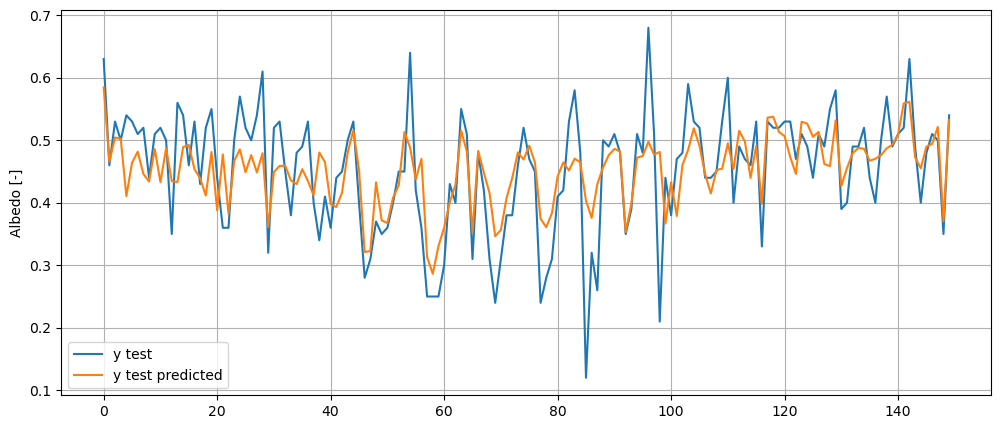

In [54]:
plt.figure(figsize=(12,5))
plt.plot(y_test[:150], label='y test')
plt.plot(y_test_pre[:150], label='y test predicted')
# plt.xlabel('Days from 1 June 2020')
plt.ylabel('Albedo [-]')
plt.legend()
plt.grid()

# Shapley

In [55]:
explainer = shap.Explainer(rf_tas.predict, X_train)
shap_values = explainer(X_test)

Permutation explainer: 24945it [7:09:57,  1.03s/it]                             


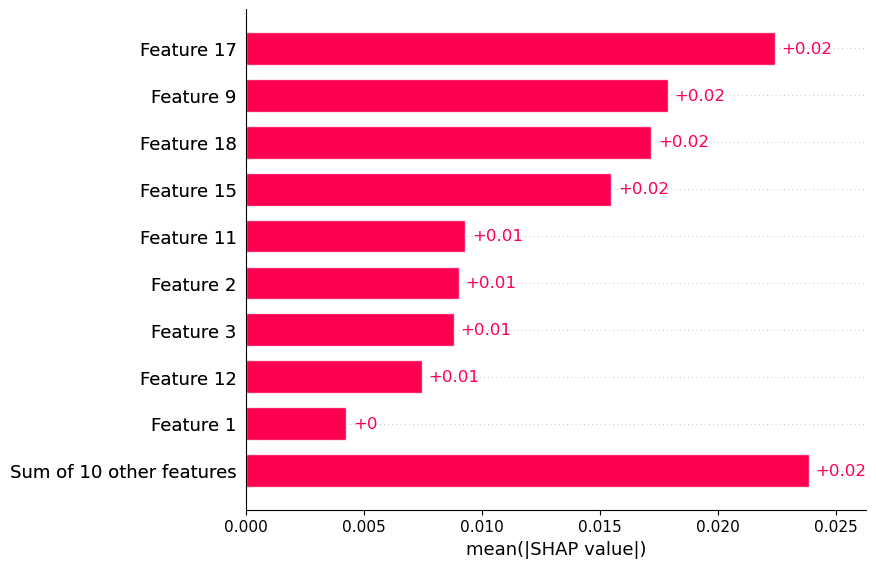

In [56]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


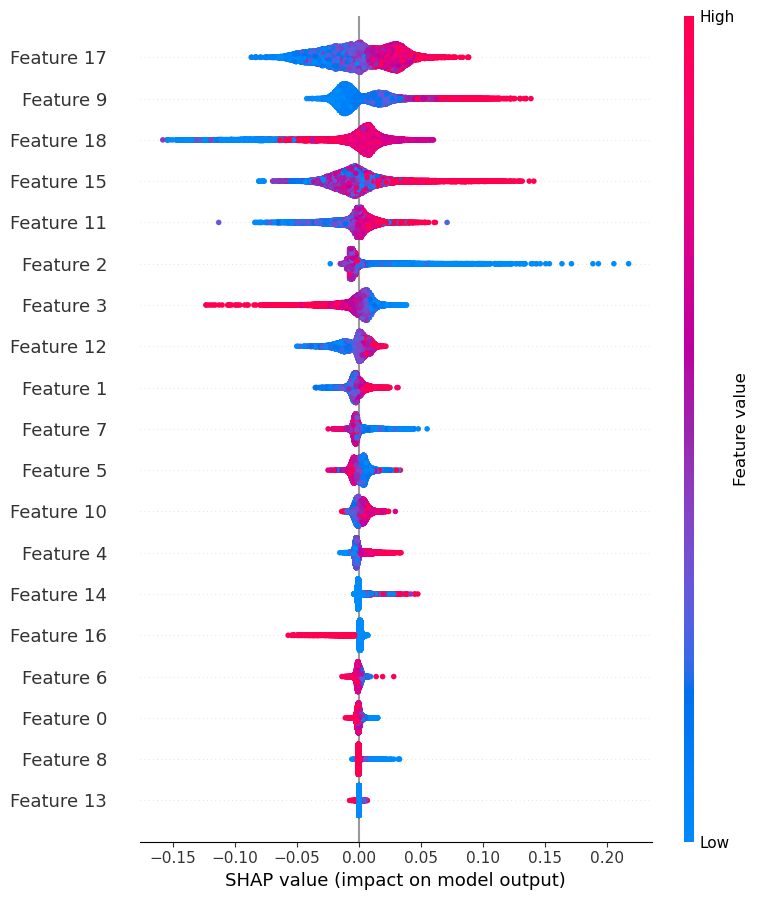

In [57]:
shap.summary_plot(shap_values)

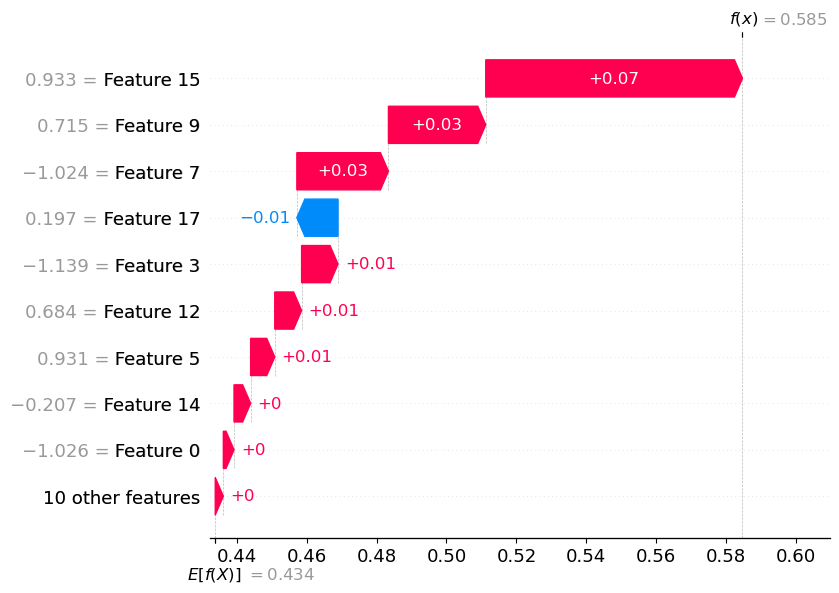

In [59]:
shap.plots.waterfall(shap_values[0])

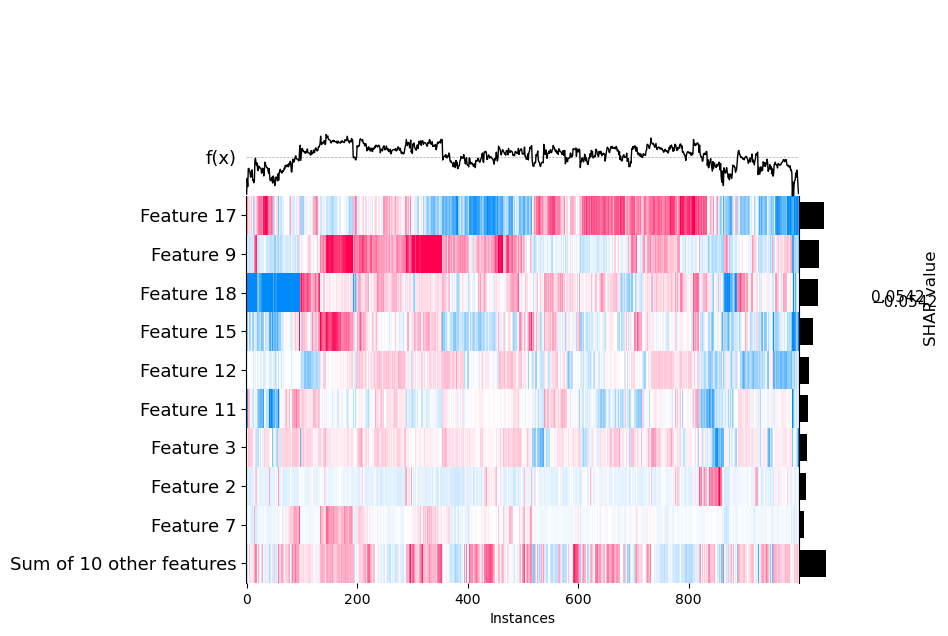

In [62]:
shap.plots.heatmap(shap_values[:1000])